In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/colorectal-cancer-patients/Colorectal Cancer Patient Data.csv
/kaggle/input/colorectal-cancer-patients/Colorectal Cancer Gene Expression Data.csv


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from xgboost import XGBClassifier,XGBRegressor


In [3]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [4]:
plt.style.use("ggplot")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [5]:
cancer_data = pd.read_csv('/kaggle/input/colorectal-cancer-patients/Colorectal Cancer Patient Data.csv', index_col=0)
print(cancer_data.shape)
cancer_data

(63, 9)


,ID_REF,Age (in years),Dukes Stage,Gender,Location,DFS (in months),DFS event,Adj_Radio,Adj_Chem
0,GSM877126,62.0,A,Male,Left,108.0,0.0,1.0,0.0
1,GSM877127,77.0,B,Male,Left,40.0,1.0,1.0,0.0
2,GSM877128,66.0,C,Female,Left,49.0,0.0,1.0,0.0
3,GSM877129,72.0,D,Female,Left,45.0,0.0,1.0,1.0
4,GSM877130,75.0,C,Male,Left,40.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
58,GSM877185,48.0,D,Male,Right,64.0,0.0,1.0,0.0
59,GSM877186,65.0,C,Male,Left,25.0,1.0,1.0,0.0
60,GSM877187,71.0,A,Male,Rectum,58.0,1.0,1.0,0.0
61,GSM877188,57.0,A,Male,Rectum,68.0,1.0,0.0,0.0


In [6]:
cancer_data.isnull().sum()

ID_REF             1
Age (in years)     1
Dukes Stage        1
Gender             1
Location           1
DFS (in months)    1
DFS event          1
Adj_Radio          1
Adj_Chem           1
dtype: int64

In [7]:
#drop empty row
cancer_data.dropna(inplace=True)
print(cancer_data.shape)

(62, 9)


In [8]:
cancer_data.describe()

,Age (in years),DFS (in months),DFS event,Adj_Radio,Adj_Chem
count,62.000000,62.000000,62.000000,62.000000,62.000000
mean,61.112903,41.774194,0.596774,0.532258,0.483871
std,9.581582,26.288076,0.494550,0.503032,0.503819
min,28.000000,4.000000,0.000000,0.000000,0.000000
25%,56.250000,19.500000,0.000000,0.000000,0.000000
50%,62.000000,38.000000,1.000000,1.000000,0.000000
75%,67.000000,57.500000,1.000000,1.000000,1.000000
max,78.000000,108.000000,1.000000,1.000000,1.000000


<AxesSubplot:xlabel='Age (in years)', ylabel='Count'>

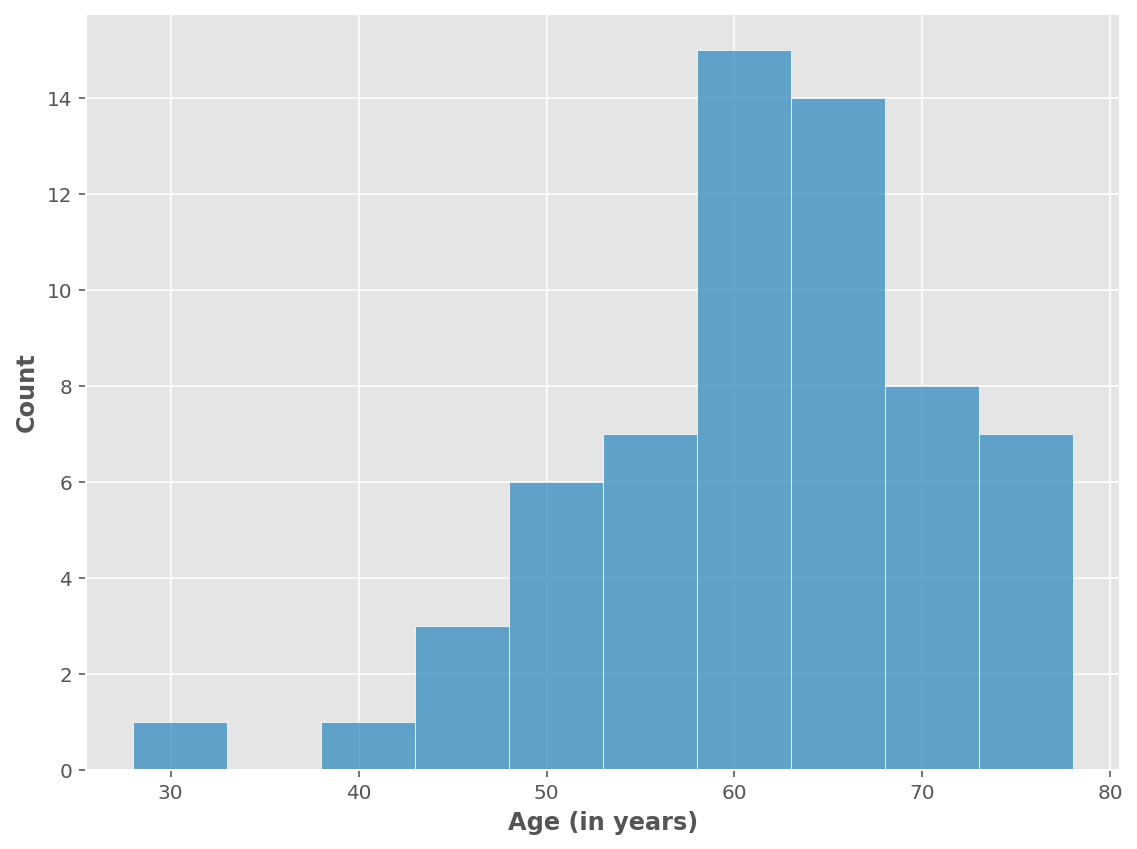

In [9]:
plt.figure(figsize=(8,6))
sns.histplot(cancer_data['Age (in years)'],)

Male      48
Female    14
Name: Gender, dtype: int64
77.4194% of patients are male and 
22.5806% of patients are female


<AxesSubplot:xlabel='Age (in years)', ylabel='Gender'>

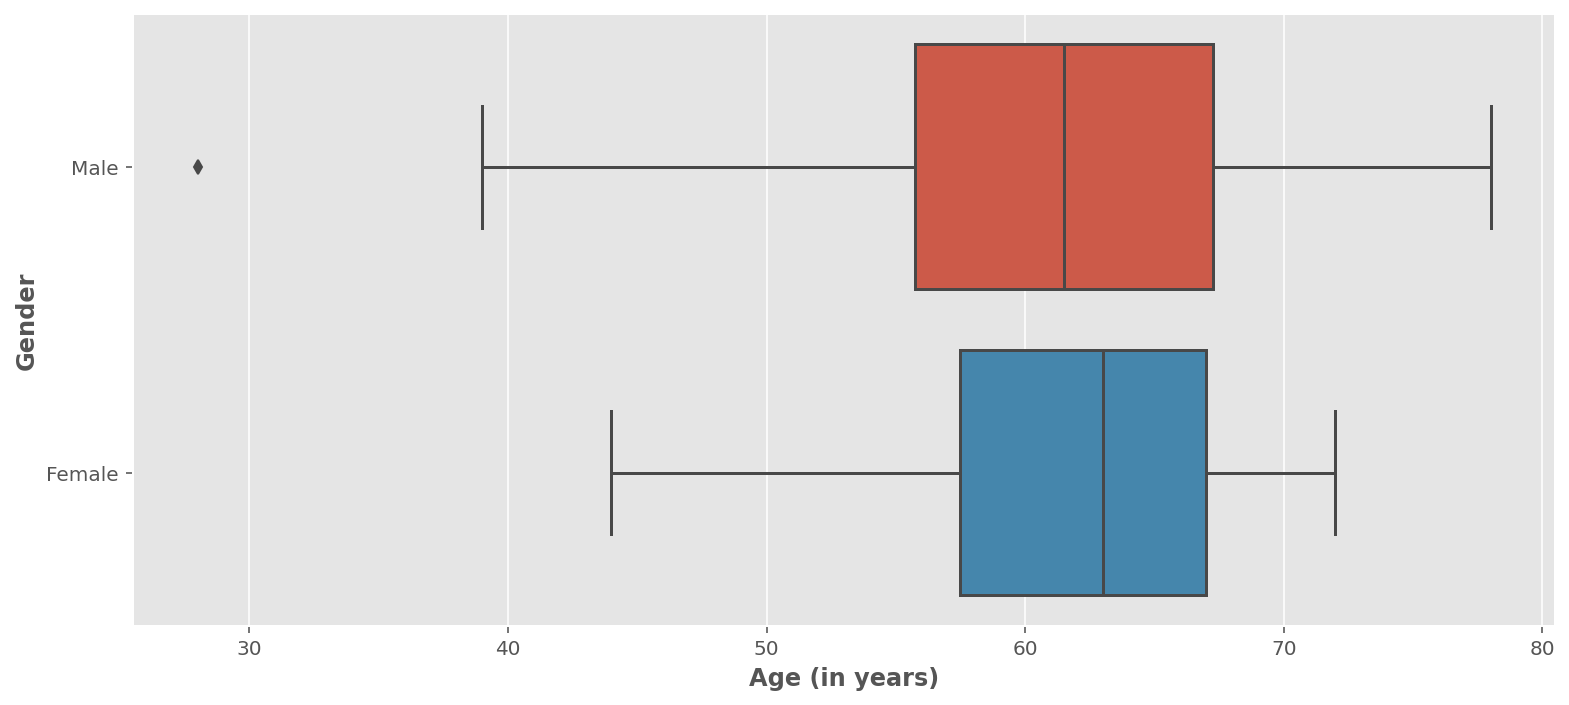

In [10]:
# Patient gender
dist = cancer_data.Gender.value_counts()
print(dist)
print(f'''{round(dist[0]/cancer_data.Gender.count()*100,4)}% of patients are male and 
{round(dist[1]/cancer_data.Gender.count()*100,4)}% of patients are female''' )
#fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,7))
#sns.catplot('Gender','Age (in years)',data=cancer_data)
sns.boxplot(y='Gender',x='Age (in years)',data=cancer_data,orient='horiz')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-package

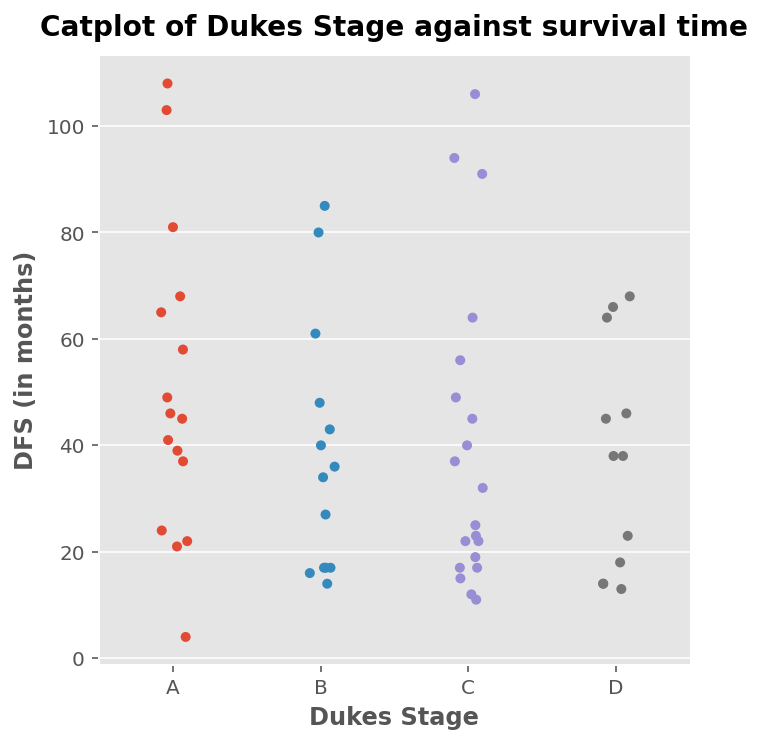

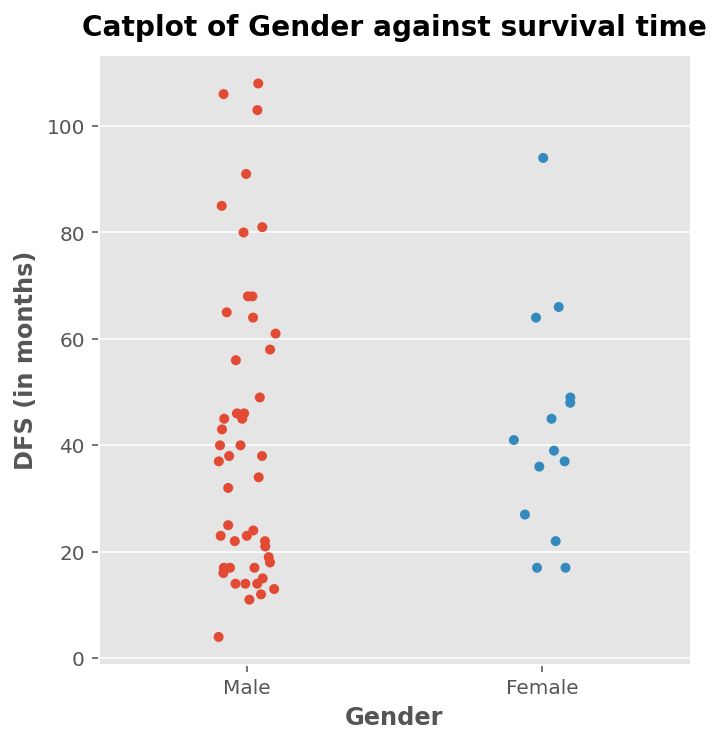

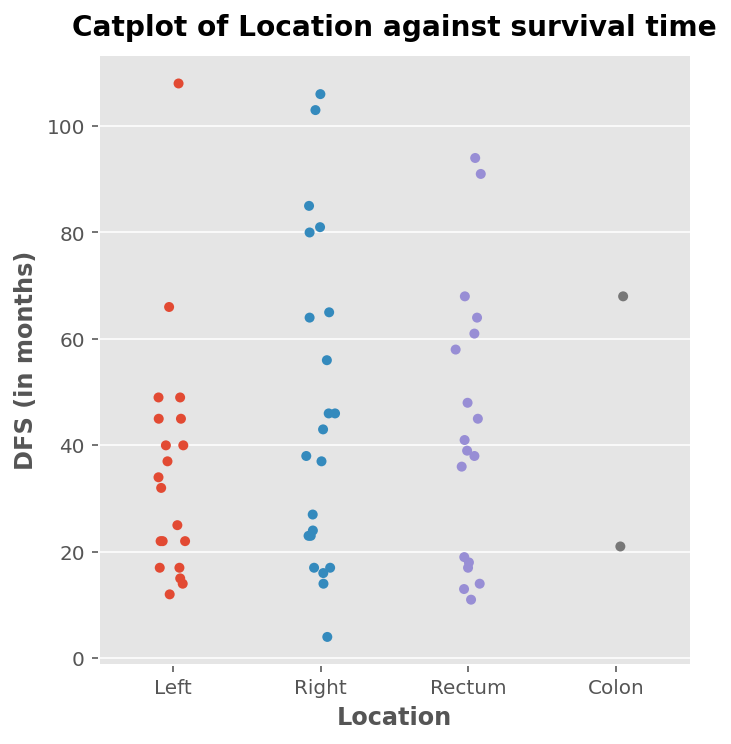

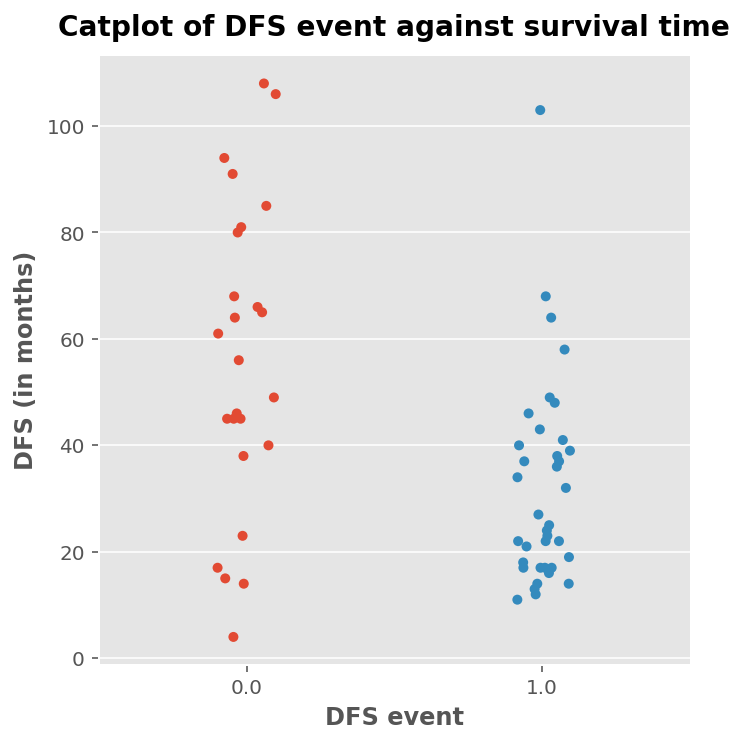

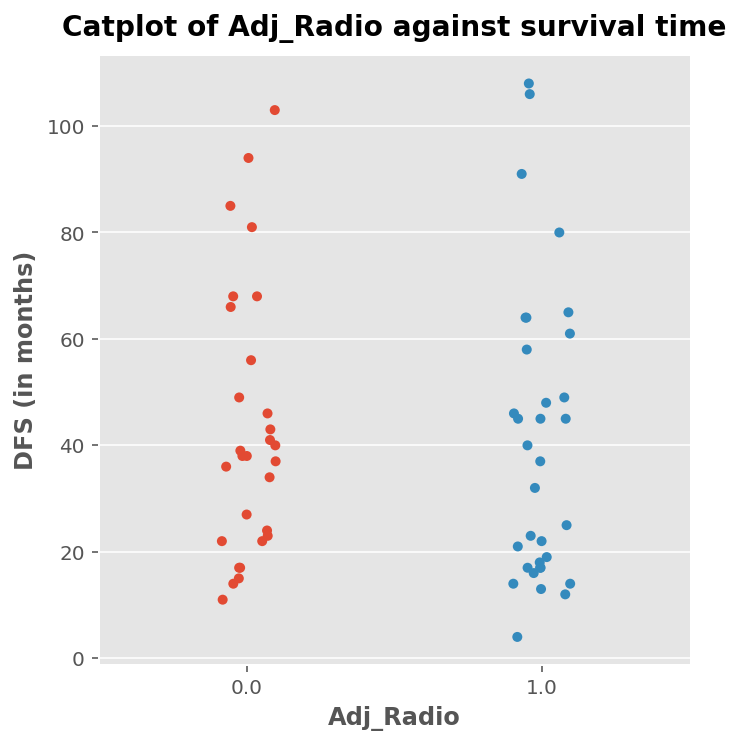

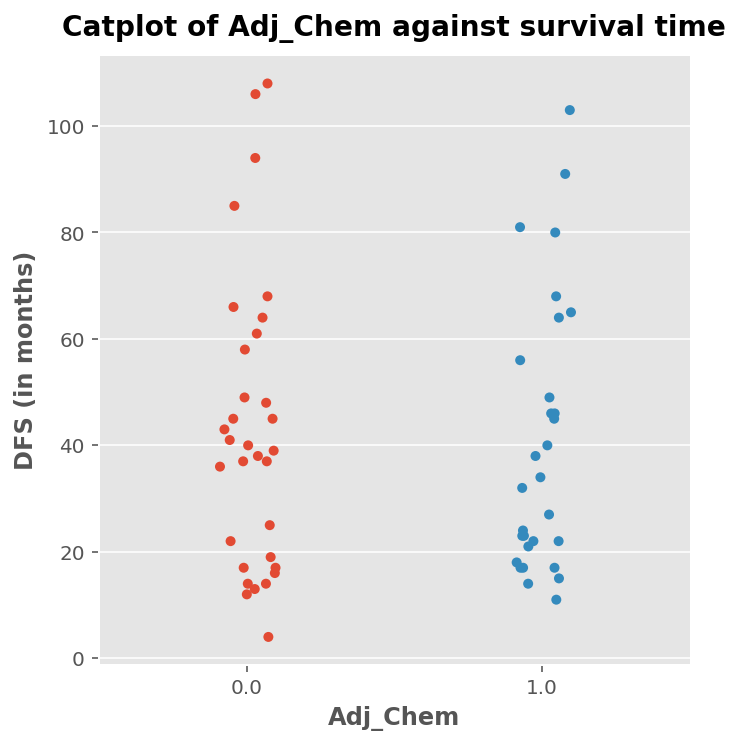

In [11]:
def plot_cat(cat):
    '''Plot categorical variables against "Disease free survival" '''
    for item in cat:
        sns.catplot(item,'DFS (in months)',data=cancer_data)
        plt.title(f'Catplot of {item} against survival time')
    
cat_var= ['Dukes Stage', 'Gender', 'Location', 'DFS event', 'Adj_Radio', 'Adj_Chem']
plot_cat(cat_var)

In [12]:
# cancer patients with no disease event after treatment
#Make copy of data
cancer_data_copy = cancer_data.copy()

cancer_data_free = cancer_data[cancer_data['DFS event'] == 0]
cancer_data_free

,ID_REF,Age (in years),Dukes Stage,Gender,Location,DFS (in months),DFS event,Adj_Radio,Adj_Chem
0,GSM877126,62.0,A,Male,Left,108.0,0.0,1.0,0.0
2,GSM877128,66.0,C,Female,Left,49.0,0.0,1.0,0.0
3,GSM877129,72.0,D,Female,Left,45.0,0.0,1.0,1.0
4,GSM877130,75.0,C,Male,Left,40.0,0.0,0.0,1.0
5,GSM877131,61.0,A,Male,Right,65.0,0.0,1.0,1.0
8,GSM877134,54.0,B,Male,Right,80.0,0.0,1.0,1.0
9,GSM877135,68.0,C,Female,Rectum,94.0,0.0,0.0,0.0
11,GSM877137,68.0,C,Male,Right,106.0,0.0,1.0,0.0
12,GSM877138,47.0,A,Male,Right,81.0,0.0,0.0,1.0
14,GSM877140,63.0,D,Male,Colon,68.0,0.0,0.0,1.0


In [13]:
#Make copy of data
cancer_data_copy = cancer_data.copy()
cancer_data_copy.drop('ID_REF',axis=1,inplace=True)

cancer_data_unf= cancer_data_copy.copy()

# Factorize categorical columns
cat_var= ['Dukes Stage', 'Gender', 'Location',]
uniques=[]
for col in cat_var:
    
    cancer_data_copy[col], unique = pd.factorize(cancer_data_copy[col])
    uniques.append(unique)
print(uniques)
cancer_data_copy

[Index(['A', 'B', 'C', 'D'], dtype='object'), Index(['Male', 'Female'], dtype='object'), Index(['Left', 'Right', 'Rectum', 'Colon'], dtype='object')]


,Age (in years),Dukes Stage,Gender,Location,DFS (in months),DFS event,Adj_Radio,Adj_Chem
0,62.0,0,0,0,108.0,0.0,1.0,0.0
1,77.0,1,0,0,40.0,1.0,1.0,0.0
2,66.0,2,1,0,49.0,0.0,1.0,0.0
3,72.0,3,1,0,45.0,0.0,1.0,1.0
4,75.0,2,0,0,40.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
57,54.0,2,0,0,22.0,1.0,0.0,0.0
58,48.0,3,0,1,64.0,0.0,1.0,0.0
59,65.0,2,0,0,25.0,1.0,1.0,0.0
60,71.0,0,0,2,58.0,1.0,1.0,0.0


In [14]:
cancer_data

,ID_REF,Age (in years),Dukes Stage,Gender,Location,DFS (in months),DFS event,Adj_Radio,Adj_Chem
0,GSM877126,62.0,A,Male,Left,108.0,0.0,1.0,0.0
1,GSM877127,77.0,B,Male,Left,40.0,1.0,1.0,0.0
2,GSM877128,66.0,C,Female,Left,49.0,0.0,1.0,0.0
3,GSM877129,72.0,D,Female,Left,45.0,0.0,1.0,1.0
4,GSM877130,75.0,C,Male,Left,40.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
57,GSM877184,54.0,C,Male,Left,22.0,1.0,0.0,0.0
58,GSM877185,48.0,D,Male,Right,64.0,0.0,1.0,0.0
59,GSM877186,65.0,C,Male,Left,25.0,1.0,1.0,0.0
60,GSM877187,71.0,A,Male,Rectum,58.0,1.0,1.0,0.0


Text(0.5, 1.0, 'Spearman Correlation')

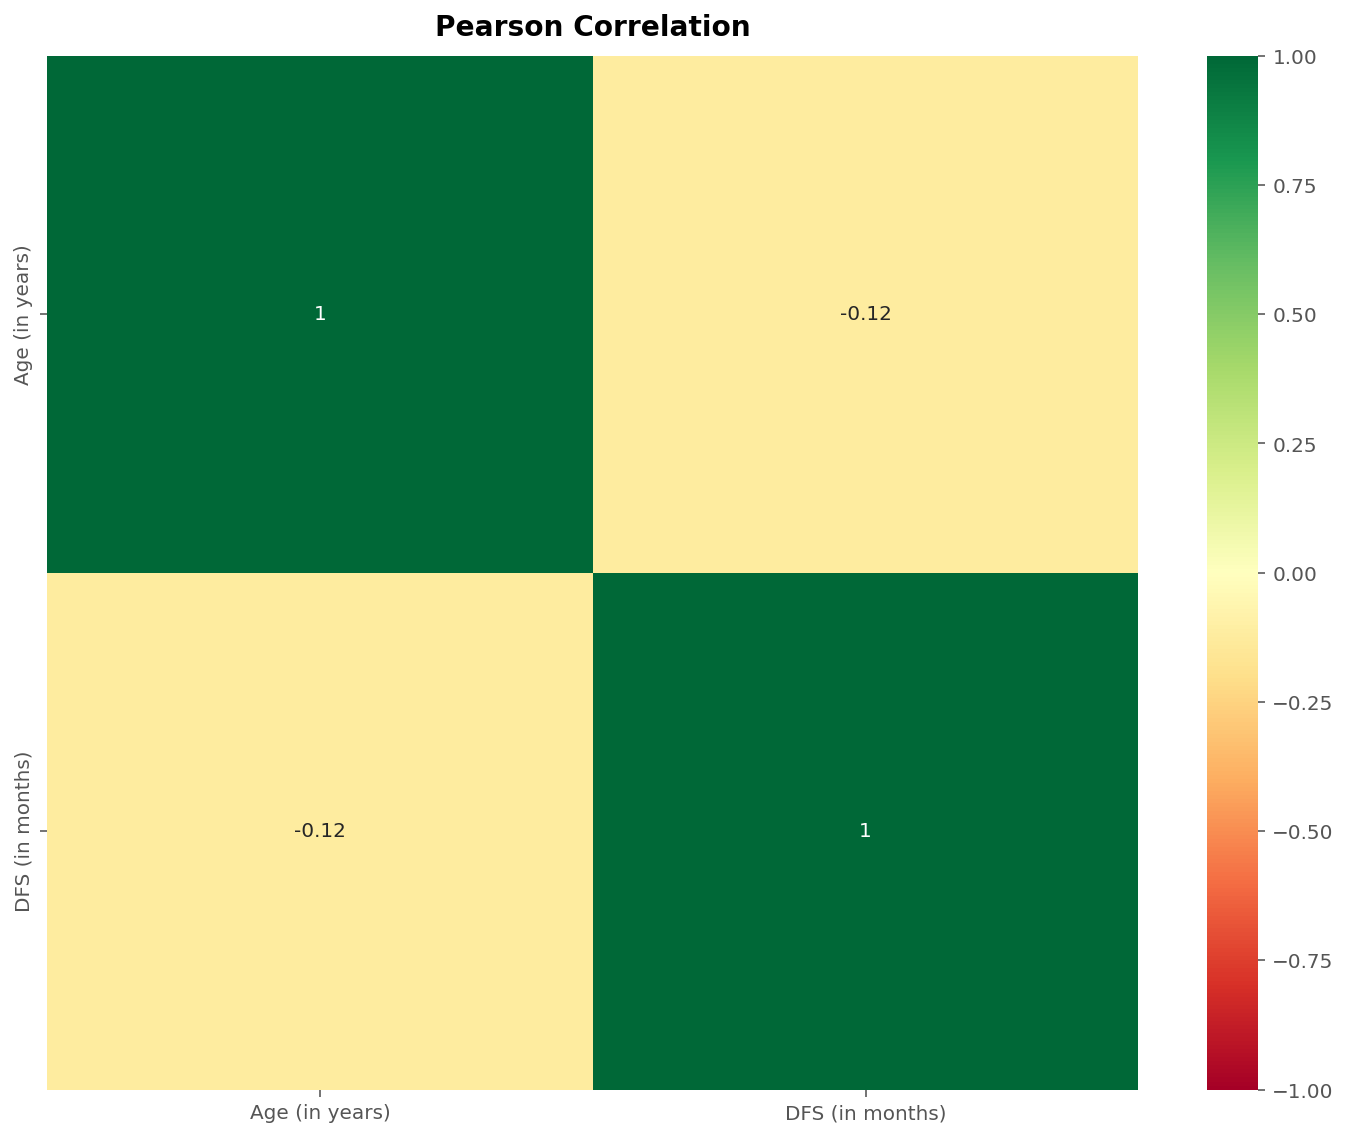

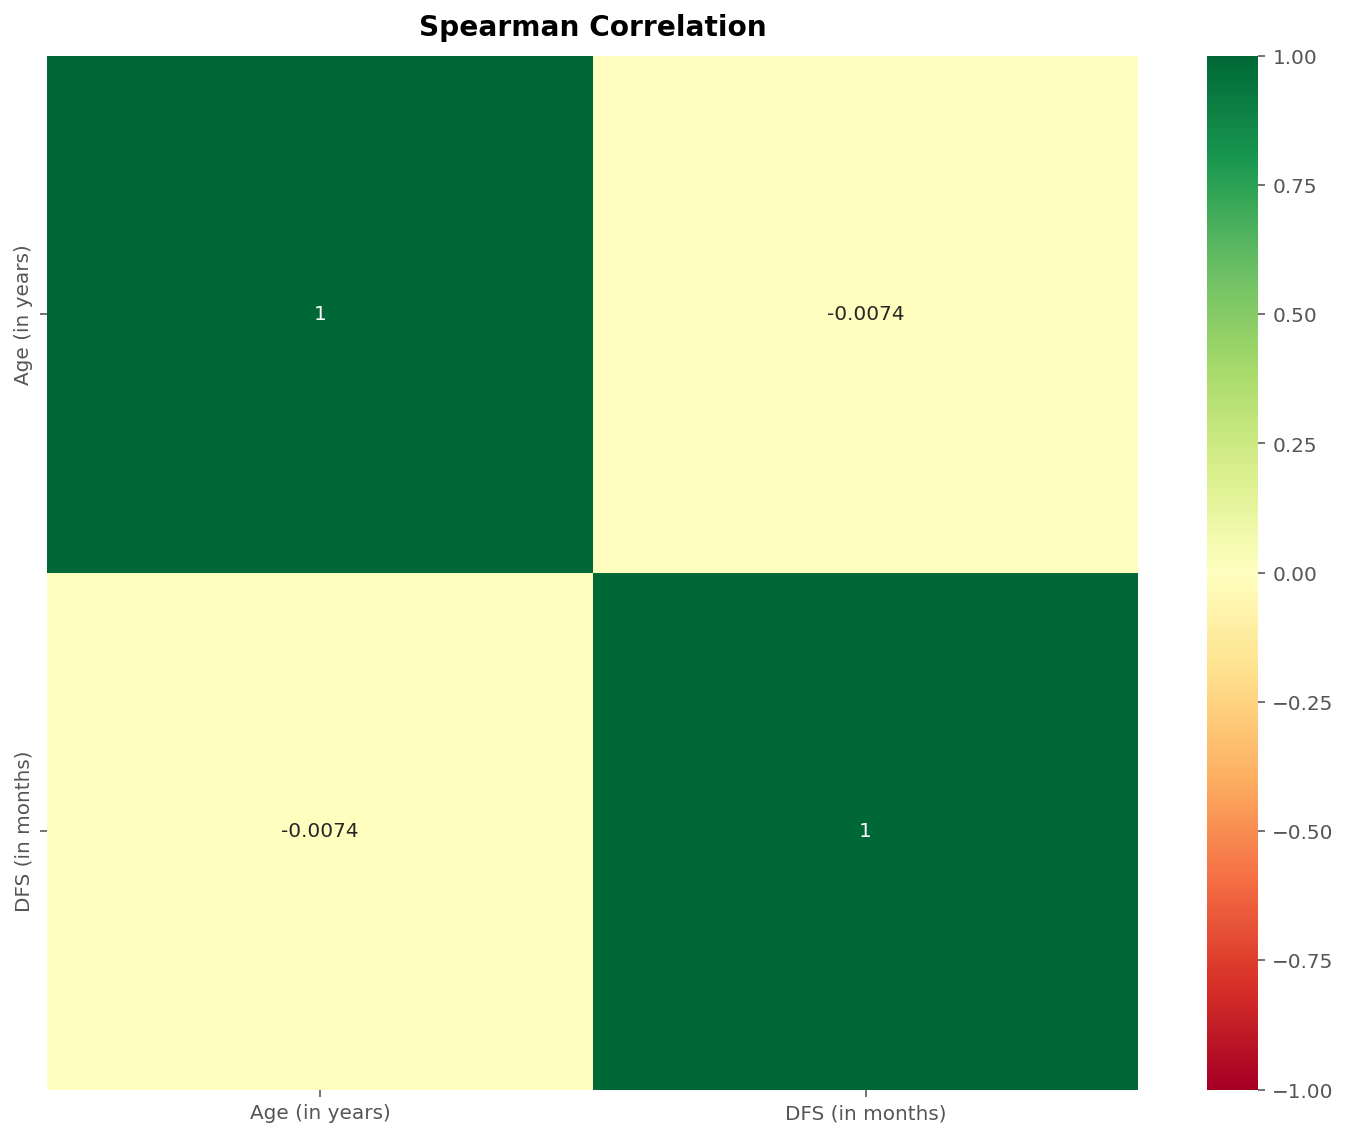

In [15]:
# Calculate correlations between disease free survival and age
cancer_data_age = cancer_data[['Age (in years)','DFS (in months)']]
corr_pearson = cancer_data_age.corr(method='pearson')
corr_spearman = cancer_data_age.corr(method='spearman')

fig = plt.figure(figsize = (10,8))
sns.heatmap(corr_pearson, annot=True, cmap='RdYlGn', vmin=-1, vmax=+1)
plt.title('Pearson Correlation')


plt.figure(figsize = (10,8))
sns.heatmap(corr_spearman, annot=True, cmap='RdYlGn', vmin=-1, vmax=+1)
plt.title('Spearman Correlation')

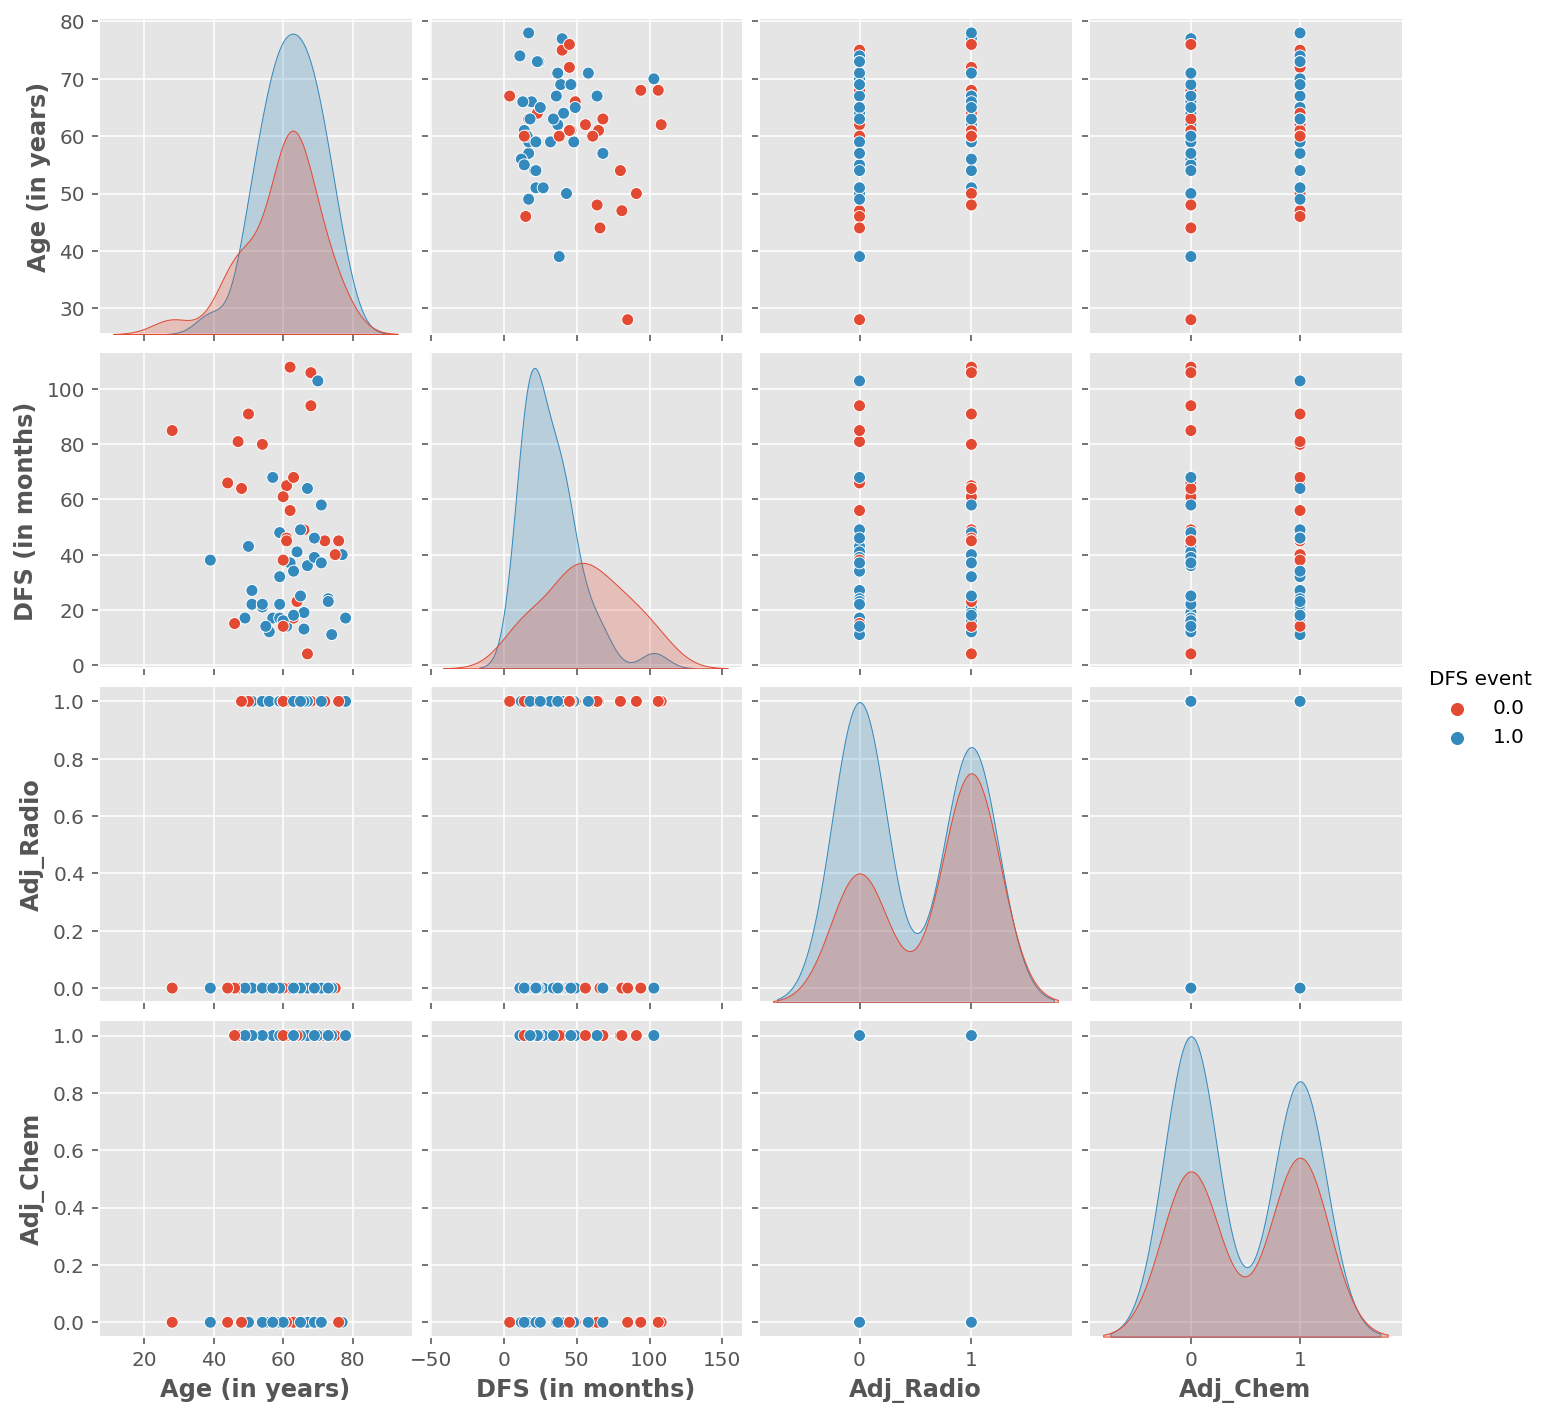

In [16]:
sns.pairplot(cancer_data_unf, hue = 'DFS event',)

In [17]:
y = cancer_data_copy['DFS event']
X = cancer_data_copy.drop(['DFS event'],axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [18]:
XGB_model = XGBClassifier()
XGB_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [19]:
result_train = XGB_model.score(X_train, y_train)
print("Accuracy : {}".format(result_train))


Accuracy : 1.0


In [20]:
result_valid = XGB_model.score(X_valid, y_valid)
print("Accuracy : {}".format(result_valid))

Accuracy : 0.8461538461538461


In [21]:
y_pred = XGB_model.predict(X_valid)
print(classification_report(y_valid, y_pred))


              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80         6
         1.0       0.78      1.00      0.88         7

    accuracy                           0.85        13
   macro avg       0.89      0.83      0.84        13
weighted avg       0.88      0.85      0.84        13



Text(0.5, 6.79999999999999, 'Actual class')

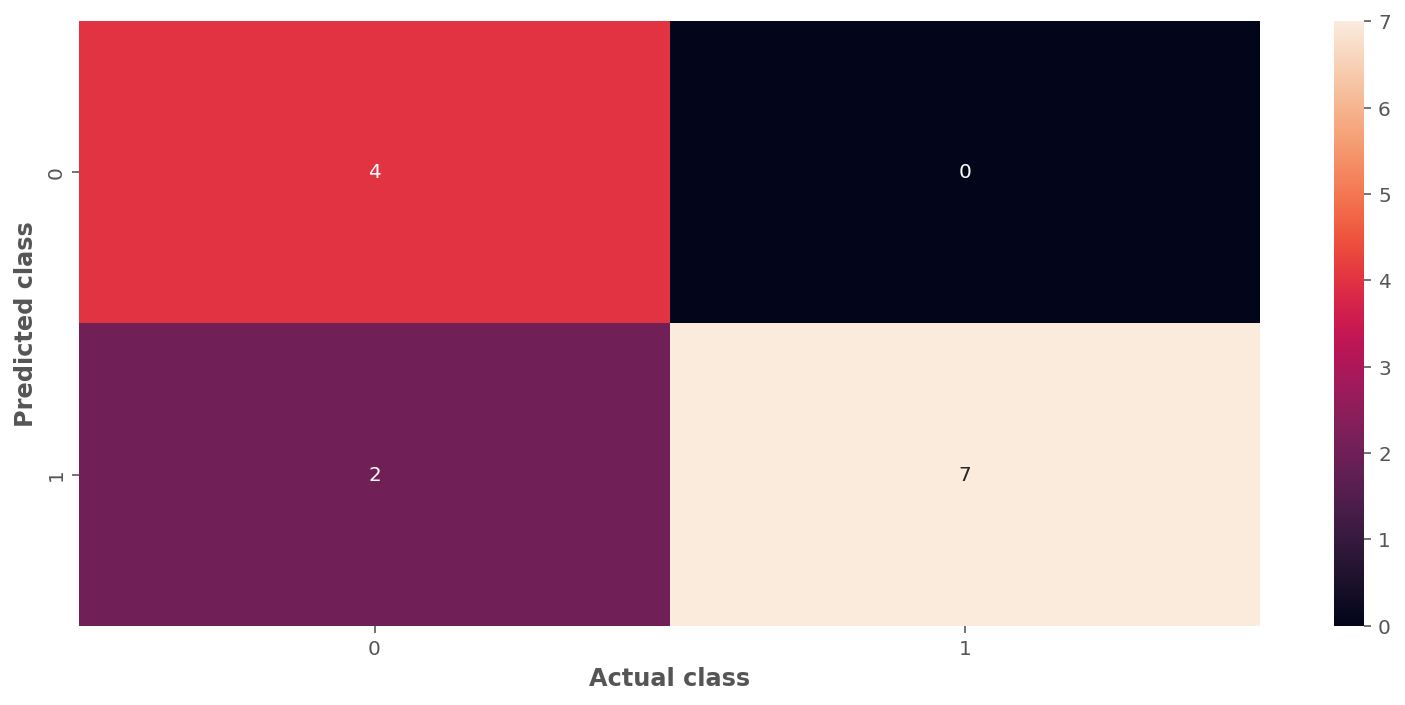

In [22]:
cm = confusion_matrix(y_pred, y_valid) 
sns.heatmap(cm, annot = True)
plt.ylabel('Predicted class')
plt.xlabel('Actual class')


In [23]:
# Key to factorized columns
uniques

[Index(['A', 'B', 'C', 'D'], dtype='object'),
 Index(['Male', 'Female'], dtype='object'),
 Index(['Left', 'Right', 'Rectum', 'Colon'], dtype='object')]